### 예제
1. csv 폴더에서 test_csv 폴더의 '오프라인.csv' 파일을 로드 
2. 컬럼의 이름을 변경 -> [기준년월, '업종', 성별, 연령대, 총이용건수, 총이용금액]
3. 결측치가 존재하는가?
    - 결측치의 대한 체크
    - 성별 컬럼에서 '-' 데이터가 존재하는가?
4. 기준년월 컬럼의 데이터 타입을 시계열 변경 
5. 성별을 기준으로 연도별 건당 이용금액의 평균이 어떻게 되는가?
    - 기준년 컬럼을 생성하여 기준년월에서 년도만 추출하여 대입
    - 건당이용금액 컬럼을 생성하여 총이용금액 / 총이용건수 의 결과를 대입
    - 기준년과 성별을 기준으로 그룹화를 하고 그룹화 연산으로는 건당이용금액의 평균을 구한다. 

In [ ]:
import pandas as pd
from datetime import datetime

In [ ]:
# 파일을 로드 
offline = pd.read_csv('../../csv/test_csv/오프라인.csv', 
    encoding='cp949')

In [ ]:
offline.head()

In [ ]:
# 컬럼의 이름을 변경
# case1 : rename() -> 특정 컬럼이나 인덱스를 변경할때 사용
# columns 변수를 변경하는것과의 차이점은 rename() 변경하기 전 확인이 가능
offline.rename(
    columns = {
        'crym' : '기준년월', 
        'tco_btc_nm' : '업종', 
        'ma_fem_dc' : '성별', 
        'agegrp_dc' : '연령대', 
        'tco_btc_u_ct' : '총이용건수', 
        'tco_btc_u_am' : '총이용금액'
    }
)

In [ ]:
# case2 : DataFrame안에 존재하는 columns 변수에 데이터를 변경 
offline.columns = ['기준년월', '업종', '성별', '연령대', 
                    '총이용건수', '총이용금액']

In [ ]:
offline.head()

In [ ]:
# 결측치의 개수를 확인 -> 결측치인가? -> 합
offline.isna().sum()

In [ ]:
offline.info()

In [ ]:
offline.describe()

In [ ]:
# 항목정의서에서 확인했을때 성별 컬럼의 결측치는 -
# - 의 개수도 확인 
(offline['성별'] == '-').sum()

In [ ]:
offline['성별'].isin(['-', '9']).sum()

In [ ]:
pd.to_datetime(offline['기준년월'] , format='%Y%m')

In [ ]:
# datetime 라이브러리 안에 존재하는 시계열로 변환하는 함수 
datetime.strptime(str(offline['기준년월'][0]), '%Y%m')

In [ ]:
offline['기준년월'] = offline['기준년월'].map(
    lambda x : datetime.strptime( str(x), '%Y%m' )
)

In [ ]:
# 기준년 컬럼을 생성하여 기준년월에서 년도만 추출하여 대입 
# case1 : map 함수를 이용
offline['기준년월'].map(
    lambda x : x.strftime('%Y')
)

In [ ]:
# case2 : Series에서 datetime 내장함수를 이용
offline['기준년월'].dt.strftime('%Y')

In [ ]:
# case3 : Series에서 dateitme 변수를 이용
offline['기준년'] = offline['기준년월'].dt.year

In [ ]:
# 건당이용금액 컬럼을 생성하여 총이용금액 / 총이용건수의 값을 대입 
offline['건당이용금액'] = \
     offline['총이용금액'] / offline['총이용건수']

In [ ]:
# 기준년, 성별을 기준으로 그룹화 -> 건당 이용금액의 평균
offline.groupby(['기준년', '성별'])[['건당이용금액']].mean()

In [ ]:
# 데이터프레임 데이터의 구조를 재 구조화 한다. 
# pivot_table() -> pandas 안에 존재, DataFrame 안에 존재 
pd.pivot_table(
    offline, 
    index = ['기준년', '성별'], 
    values = '건당이용금액', 
    aggfunc = 'mean'
)

In [ ]:
offline.pivot_table(
    index = ['기준년', '성별'], 
    values = '총이용건수', 
    aggfunc = 'sum'
)

In [ ]:
# 기준년월, 업종별 총 이용금액의 합계를 확인
group_data = \
     offline.groupby([ '기준년월', '업종' ])[['총이용금액']].sum()

In [ ]:
import matplotlib.pyplot as plt
import platform

In [ ]:
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='Malgun Gothic')

In [ ]:
group_data = group_data.unstack()

In [ ]:
group_data.columns

In [ ]:
# 그래프에서 지수표현식을 제거 
plt.ticklabel_format(axis='y', style='plain', useMathText=True)
x = group_data.index
y1 = group_data[('총이용금액',  '백화점')]
y2 = group_data[('총이용금액',  '슈퍼마켓')]

plt.plot(x, y1, label='백화점')
plt.plot(x, y2, label='슈퍼마켓')
plt.legend()
plt.show()
# group_data.unstack().plot()

- 온라인, 오프라인 카드 사용 내역 데이터를 확인 
    1. csv 폴더 안에 test_csv에서 온라인, 오프라인 데이터를 로드
    2. 두개의 데이터프레임의 구조를 확인
    3. 두개의 데이터프레임을 결합 
        - 조인결합? -> 조건에 맞게 열을 결합 
            - 두개의 데이터프레임이 같은 열의 데이터가 1개 이상 
            - 다른 열의 데이터가 다수가 존재 
        - 유니언결합 -> 단순한 행이나 열의 결합
            - 컬럼의 구조가 같다면 -> 단순한 행 결합 
            - 인덱스의 구조가 같다면 ->단순한 열 결합
    4. 기준년월 컬럼의 데이터를 시계열 변경 
    5. 기준년월, 업종을 기준으로 하여 총이용금액의 합산을 시각화 해서 표시 

In [ ]:
offline = pd.read_csv('../../csv/test_csv/오프라인.csv', 
                      encoding='cp949')

In [ ]:
online = pd.read_csv("../../csv/test_csv/온라인.csv")

In [ ]:
# 데이터의 구조를 파악 
offline.info()

In [ ]:
online.info()

In [ ]:
# 2개의 데이터프레임은 업종이라는 부분을 제외한 나머지의 구조가 
# 같은 형태 ->  online 데이터에서 업종을 추가하고 결합 
# 단순한 결합 -> 업종 부분에 결측치를 온라인으로 채워준다. 

# 단순한 행 결합 
# concat() -> pandas에 존재 -> 단순 결합의 형태이기 때문에
# 결합이 되는 데이터프레임의 개수의 제한 없음 -> 
# 여러개의 데이터프레임을 리스트의 형태로 입력
# 행으로 결합할것인가? 열로 결합할것인가?  지정 -> axis
# 결합이되는 기준을 초기화할것인가? ignore_index

df = pd.concat( [offline, online], axis=0 )

In [ ]:
# 결측치의 개수를 확인 
df.isna().sum()

In [ ]:
# fillna() : 결측치를 특정 데이터로 채워준다. 
#     method 
        # ffill : 전 행의 데이터가 존재한다면 
        #           해당 데이터로 결측치를 채운다.
        # bfill : 후 행의 데이터가 존재한다면
        #           해당 데이터로 결측치를 채운다.
    # inplace = True는 스리즈 데이터가 전체일때만 가능
df['tco_btc_nm'].fillna('온라인', inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
# 같은 데이터의 구조지만 컬럼의 이름이 다른 경우
# offline과 online 컬럼의 이름을 변경하고 
# online에 업종 컬럼을 추가해서 '온라인' 대입 
# 단순한 행 결합 
offline.columns = ['기준년월', '업종', '성별', '연령대', 
                   '총이용건수', '총이용금액']

In [ ]:
online.columns = ['기준년월', '성별', '연령대', 
                  '총이용건수', '총이용금액']

In [ ]:
online['업종'] = "온라인"

In [ ]:
online.head()

In [ ]:
offline.head()

In [ ]:
card_df = pd.concat(
    [offline, online],
    axis=0, 
    ignore_index=True
)

In [ ]:
# 성별 컬럼의 데이터중 9와 -가 존재하는가?
((card_df['성별'] == '-') 
 | (card_df['성별'] == '9')).sum()

In [ ]:
(
    card_df['성별'].isin(['-', '9'])
).sum()

In [ ]:
card_df['성별'].value_counts()

In [ ]:
card_df['성별'].unique()

In [ ]:
# 성별 컬럼의 데이터를 1이면 남자 2이면 여자로 변경 
# case1 : 인덱스의 조건을 성별이 1이라면 컬럼의 조건은 성별
# 안의 values를 남자
df2 = card_df.copy()

In [ ]:
flag_idx = df2['성별'] == 1
flag_idx2 = df2['성별'] == 2

df2.loc[flag_idx, '성별'] = '남자'
df2.loc[flag_idx2, '성별'] = '여자'

In [ ]:
df2['성별'].value_counts()

In [61]:
# map 함수를 이용해서 남 여 변경 
df3 = card_df.copy()

In [ ]:
# map + 일반 함수
def change(x):
    if x == 1:
        result = '남자'
    elif x == 2:
        result = '여자'
    elif x == 9:
        result = '무관'
    else:
        result = '결측'
    return result

df3['성별'].map(
    change
)

In [ ]:
# map + lambda
# 한줄로 표현하는 if 조건식
# "조건식이 참인경우의 데이터" if 조건식 else (거짓인 경우 데이터)
df3['성별'].map(
    lambda x : '남자' if (x == 1) else '여자'
)

In [ ]:
_dict = {1: '남자', 2 : '여자'}
df3['성별'].map(
    lambda x : _dict[x]
)

In [65]:
# replace( '찾는 문자열', '치환될 문자열' )
# replace( { '찾는문자열' : '치환될 문자열', ... } )
df3['성별'].replace(_dict)

0       남자
1       남자
2       남자
3       남자
4       남자
        ..
3294    여자
3295    여자
3296    여자
3297    여자
3298    여자
Name: 성별, Length: 3299, dtype: object

In [67]:
_list = []

for idx in range(0, len(df3), 1):
    # print(df3.loc[idx, '성별'])
    # break
    if df3.loc[idx, '성별'] == 1:
        _list.append('남자')
    else:
        _list.append('여자')

In [ ]:
_list

In [69]:
for idx in range(len(df3)):
    if df3.loc[idx, '성별'] == 1:
        df3.loc[idx, '성별'] = '남자'
    else:
        df3.loc[idx, '성별'] = '여자'

C:\Users\moons\AppData\Local\Temp\ipykernel_2412\3664172565.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '남자' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df3.loc[idx, '성별'] = '남자'


In [70]:
df3['성별'].value_counts()

성별
여자    1661
남자    1638
Name: count, dtype: int64

In [71]:
card_df['기준년월'] = pd.to_datetime(
    card_df['기준년월'], format='%Y%m'
)

In [ ]:
card_df.info()

In [73]:
group_data = card_df.groupby(
    ['기준년월', '업종']
)['총이용금액'].sum()

In [78]:
group_data2 = group_data.unstack()

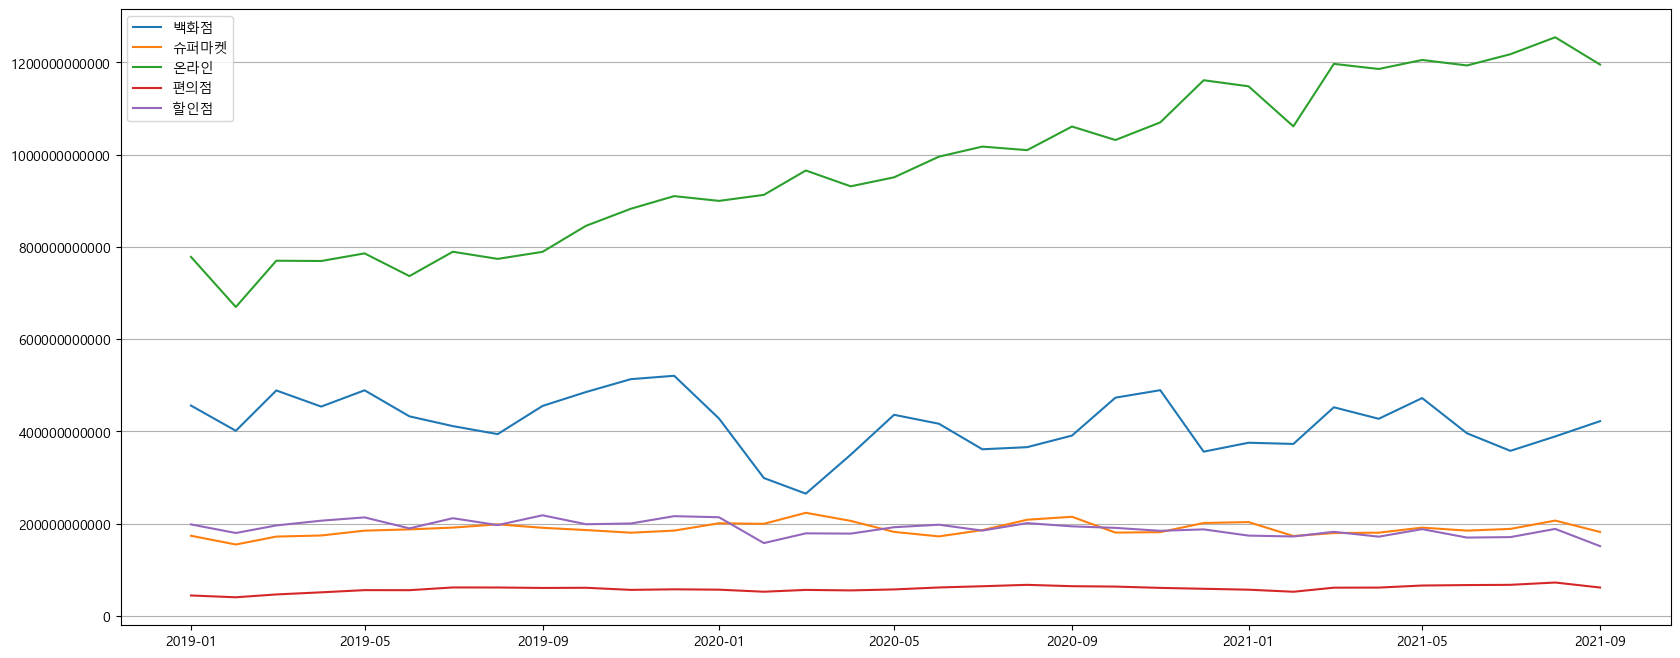

In [79]:
x = group_data2.index

y1 = group_data2['백화점']
y2 = group_data2['슈퍼마켓']
y3 = group_data2['온라인']
y4 = group_data2['편의점']
y5 = group_data2['할인점']

# 그래프의 사이즈를 변경 
plt.figure(figsize=(20, 8))
# 그래프에서 지수표현식을 제거 
plt.ticklabel_format(axis='y', style='plain', useMathText=True)
# y축에 그리드 선을 추가 
plt.grid(True, axis='y')
plt.plot(x, y1, label='백화점')
plt.plot(x, y2, label='슈퍼마켓')
plt.plot(x, y3, label='온라인')
plt.plot(x, y4, label='편의점')
plt.plot(x, y5, label='할인점')

# 그래프의 범례 추가 
plt.legend()
plt.show()